# 1. Introduction
- 이 노트는 기본 학습 모델, 특히 스태킹으로 알려진 앙상발의 조합 방법에 대한 매우 기본적이고 간단한 입문서입니다. 간단히 말해 몇가지 기본 분류기의 예측을 첫 번째 수준으로 사용한 다음 두 번째 수준에서 다른 모델을 사용하여 이전 첫 번째 수준 예측의 출력을 예측합니다.

In [1]:
pip install plotly

Note: you may need to restart the kernel to use updated packages.


In [2]:
import pandas as pd
import numpy as np
import re
import sklearn
import xgboost as xgb
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

import plotly.offline as py
py.init_notebook_mode(connected=True)
import plotly.graph_objs as go
import plotly.tools as tls

import warnings
warnings.filterwarnings('ignore')

from sklearn.ensemble import (RandomForestClassifier, AdaBoostClassifier, 
                                GradientBoostingClassifier, ExtraTreesClassifier)
from sklearn.svm import SVC
from sklearn.model_selection import KFold

# 2. Feature Exploration, Engineering and Cleaning

- 일반적으로 대부분의 커널이 구조화되는 방식과 매우 유사하게 진행될 것이며
- 먼저 보유한 데이터를 탐색하고
- 가능한 feature engineering 기회를 식별하고
- 모든 범주형 feature을 수치화시킴.

## 2-1. Feature Exploration

In [3]:
# Load in the train and test datasets
train = pd.read_csv("../input/titanic/train.csv")
test = pd.read_csv("../input/titanic/train.csv")

# Store out passenger ID for easy access
PassengerId = test['PassengerId']

train.head(3)

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S


## 2-2. Feature Engineering

In [4]:
full_data = [train,test]

# Some features of my own that I have added in
# Gives the length of the name

# apply 함수 : 행 또는 열 또는 전체의 셀(=원소)에 원하는 연산을 지원
train['Name_length'] = train['Name'].apply(len)
test['Name_length'] = test['Name'].apply(len)

# Feature that tells whether a passenger had a cabin on the Titanic
train['Has_Cabin'] = train['Cabin'].apply(lambda x: 0 if type(x)==float else 1)
test['Has_Cabin'] = test['Cabin'].apply(lambda x: 0 if type(x)==float else 1)

In [5]:
# Create new feature FamilySize as a combination of SibSp and Parch
for dataset in full_data:
    dataset['FamilySize'] = dataset['SibSp'] + dataset['Parch'] + 1

# Create new feature IsAlone from FamilySize
for dataset in full_data:
    dataset['IsAlone'] = 0
    dataset.loc[dataset['FamilySize'] == 1, 'IsAlone'] = 1

In [6]:
# Remove all NULLS in the Embarked column
for dataset in full_data:
    dataset['Embarked'] = dataset['Embarked'].fillna('S')

# Remove all NULLS in the Fare column and create a new feature CategoricalFare
for dataset in full_data:
    dataset['Fare'] = dataset['Fare'].fillna(train['Fare'].median())
train['CategoricalFare'] = pd.qcut(train['Fare'],4)

In [7]:
# Create a New feature CategoricalAge
for dataset in full_data:
    age_avg = dataset['Age'].mean()
    age_std = dataset['Age'].std()
    age_null_count = dataset['Age'].isnull().sum()
    age_null_random_list = np.random.randint(age_avg - age_std, age_avg + age_std,
                                            size = age_null_count)
    dataset['Age'][np.isnan(dataset['Age'])] = age_null_random_list
    dataset['Age'] = dataset['Age'].astype(int)
train['CategoricalAge'] = pd.cut(train['Age'],5)

In [8]:
# Define function to extract titles from passenger names
def get_title(name):
    title_search = re.search(' ([A-Za-z]+)\.', name)
    # If the title exists, extract and return it.
    if title_search:
        return title_search.group(1)
    return ""

# Create a new feature Title, Containing the titles of passenger names
for dataset in full_data:
    dataset['Title'] = dataset['Name'].apply(get_title)
# Group all non-common titles into one single grouping "Rare"
for dataset in full_data:
    dataset['Title'] = dataset['Title'].replace(['Lady', 'Countess','Capt', 
                                                 'Col','Don', 'Dr', 'Major', 
                                                 'Rev', 'Sir', 'Jonkheer', 
                                                 'Dona'], 'Rare')

    dataset['Title'] = dataset['Title'].replace('Mile','Miss')
    dataset['Title'] = dataset['Title'].replace('Ms','Miss')
    dataset['Title'] = dataset['Title'].replace('Mme','Mrs')

In [9]:
for dataset in full_data:
    # Mapping Sex
    dataset['Sex'] = dataset['Sex'].map({'female':0,'male':1}).astype(int)

    # Mapping titles
    title_mapping = {"Mr":1,"Miss":2,"Mrs":3,"Master":4,"Rare":5}
    dataset['Title'] = dataset['Title'].map(title_mapping)
    dataset['Title'] = dataset['Title'].fillna(0)

    # Mapping Embarked
    dataset['Embarked'] = dataset['Embarked'].map({'S':0,'C':1,'Q':2}).astype(int)

    # Mapping Fare
    dataset.loc[dataset['Fare']<=7.91,'Fare'] = 0
    dataset.loc[(dataset['Fare']>7.91)&(dataset['Fare']<=14.454),'Fare'] = 1
    dataset.loc[(dataset['Fare']>14.454)&(dataset['Fare']<=31),'Fare'] = 2
    dataset.loc[(dataset['Fare']>31),'Fare'] = 3
    dataset['Fare'] = dataset['Fare'].astype(int)

    # Mapping Age
    dataset.loc[dataset['Age'] <= 16,'Age'] = 0
    dataset.loc[(dataset['Age'] > 16)&(dataset['Age']<=32),'Age'] = 1
    dataset.loc[(dataset['Age'] > 32)&(dataset['Age']<=48),'Age'] = 2
    dataset.loc[(dataset['Age'] > 48)&(dataset['Age']<=64),'Age'] = 3
    dataset.loc[(dataset['Age'] > 64),'Age'] = 4

## 2-3. Feature Selection

In [10]:
drop_elements = ['PassengerId','Name','Ticket','Cabin','SibSp']
train = train.drop(drop_elements, axis = 1)
train = train.drop(['CategoricalAge','CategoricalFare'],axis =1)
test = test.drop(drop_elements,axis = 1)

In [11]:
test.columns

Index(['Survived', 'Pclass', 'Sex', 'Age', 'Parch', 'Fare', 'Embarked',
       'Name_length', 'Has_Cabin', 'FamilySize', 'IsAlone', 'Title'],
      dtype='object')

- 기능을 정리하고 관련 정보를 추출하고 범주형 열을 삭제한 후
- feature들은 모두 기계학습 모델에 입력하기에 적합한 형식인 숫자여야함.
- 계속 진행하기 전에 변환된 데이터 세트의 간단한 상관 관계 및 분포도를 생성하여 ho를 관찰할 예정.

## 2-4. Visualizations

In [12]:
train.head(3)

,Survived,Pclass,Sex,Age,Parch,Fare,Embarked,Name_length,Has_Cabin,FamilySize,IsAlone,Title
0,0,3,1,1,0,0,0,23,0,2,0,1.0
1,1,1,0,2,0,3,1,51,1,2,0,3.0
2,1,3,0,1,0,1,0,22,0,1,1,2.0


**Pearson Correlation Heatmap**

상관관계 플롯을 생성하여 한 feature이 다른 feature과 얼마나 관련있는지 확인

<Axes: title={'center': 'Pearson Correlation of Features'}>

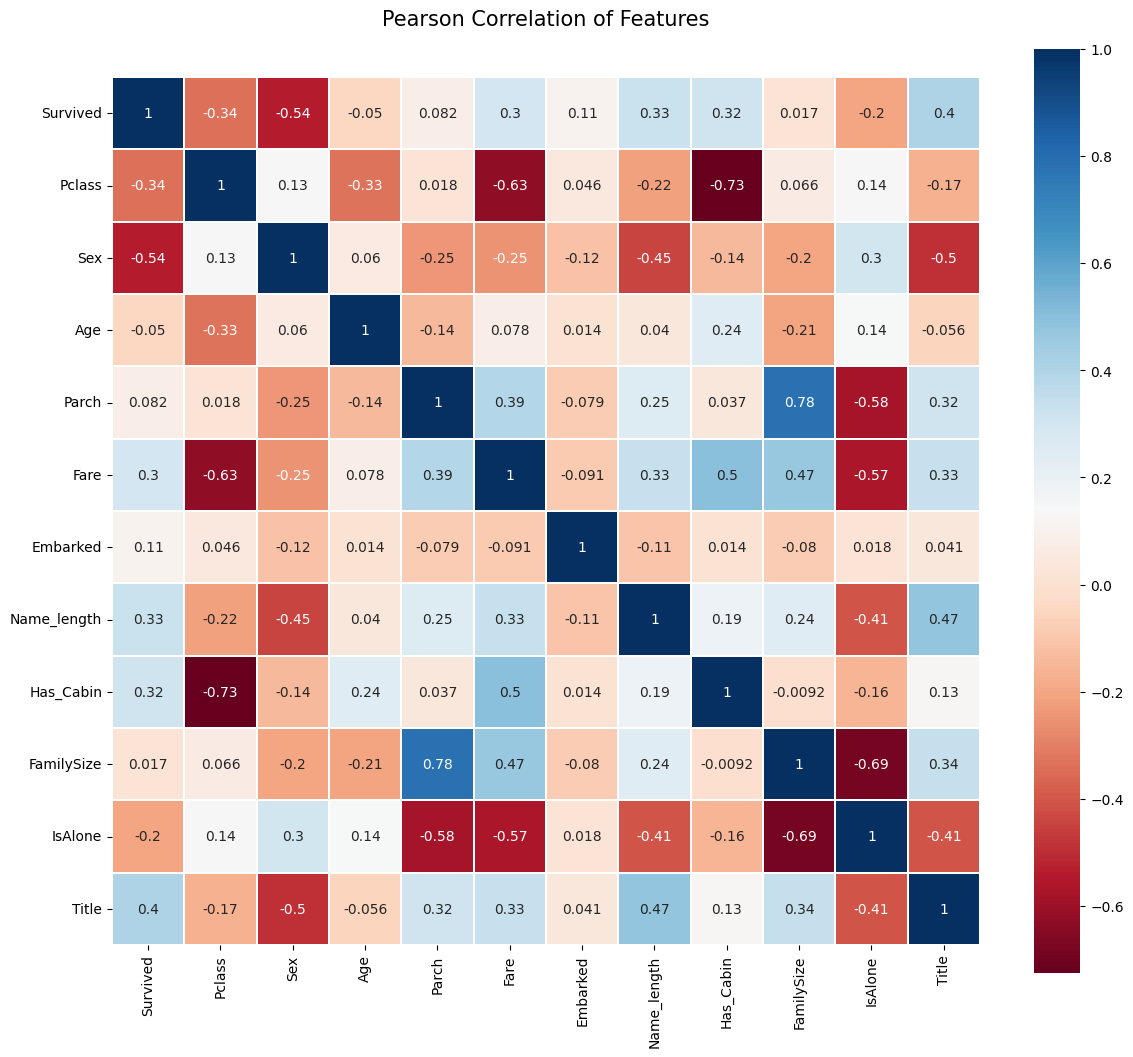

In [13]:
colormap = plt.cm.RdBu
plt.figure(figsize=(14,12))
plt.title('Pearson Correlation of Features',y=1.05,size=15)
sns.heatmap(train.astype(float).corr(),linewidths=0.1,vmax=1.0,
           square=True, cmap=colormap, linecolor='white',annot=True)

피어슨 상관관계 플로세서 알 수 있는 한가지는 서로 밀접한 상관관계가 있는 feature이 너무 많지 않다는 것.
이는 학습 모델에 이러한 feature을 제공하는 관점에서 볼 때 train세트에 중복되거나 불필요한 데이터가 많지 않다는 것을 의미하며 각 feature에 고유한 정보가 포함되어 있다는 점에서 좋음.
가장 상관관계가 높은 두가지 feature은 FamilySize와 Parch(부모 및 자녀)의 feature임

**Pairplots**

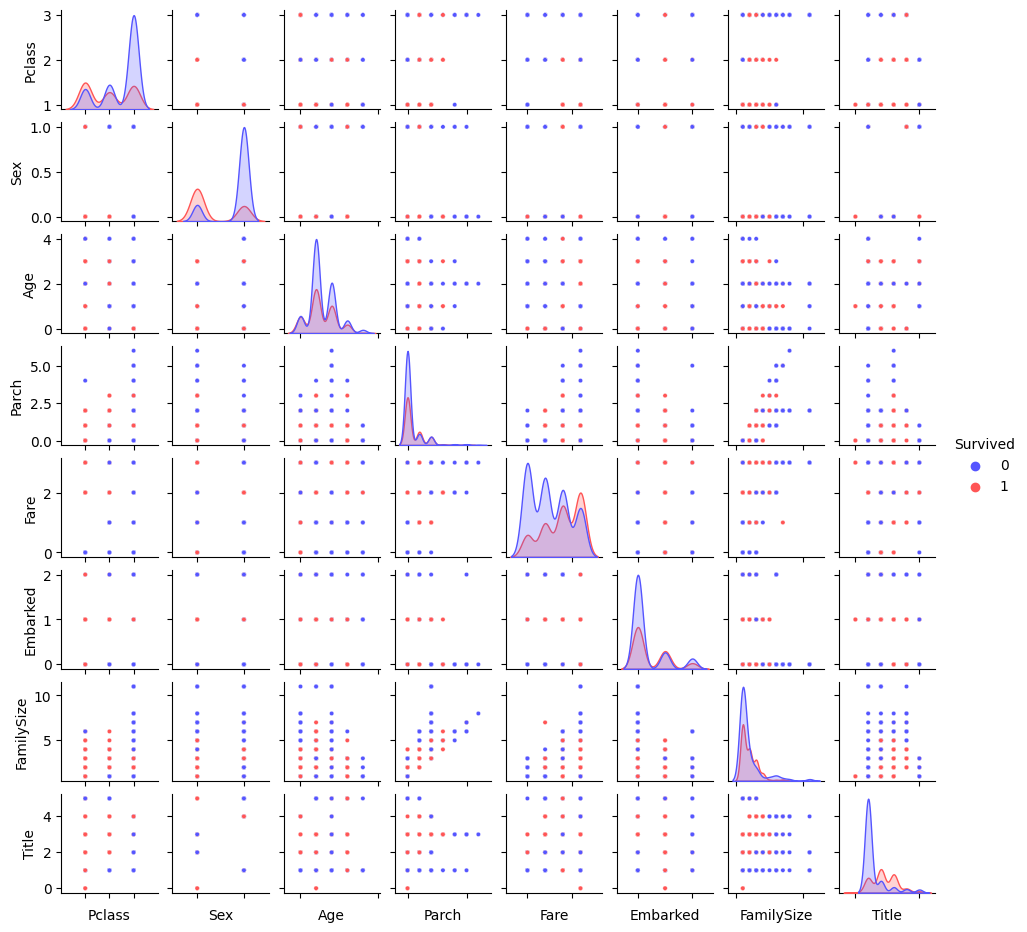

In [14]:
g = sns.pairplot(train[[u'Survived',u'Pclass',u'Sex',u'Age',u'Parch',u'Fare',
                        u'Embarked',u'FamilySize',u'Title']],hue='Survived',
                palette = 'seismic',size=1.2,diag_kind = 'kde',
                diag_kws=dict(shade=True),plot_kws=dict(s=10))
g.set(xticklabels=[])

# 3. Ensembling & Stacking models

In [15]:
# Some useful parameters which will come in handy later on

ntrain = train.shape[0]
ntest = test.shape[0]
SEED = 0 # for reproducibility
NFOLDS = 5 # set folds for out-of-fold prediction
kf = KFold(n_splits=NFOLDS, shuffle=True, random_state=SEED)

# Class to extend the Sklearn classifier
class SklearnHelper(object):
    def __init__(self,clf,seed=0,params=None):
        params['random_state'] = seed
        self.clf = clf(**params)

    def train(self, x_train, y_train):
        self.clf.fit(x_train, y_train)

    def predict(self, x):
        return self.clf.predict(x)

    def fit(self, x, y):
        return self.clf.fit(x,y)

    def feature_importances(self,x,y):
        print(self.clf.fit(x,y).feature_importances_)

# Class to extend XGboost classifier

**def init** : 클래스에 대한 기본 생성자를 호출하기 위한 파이썬 표준. 즉, 객체(classifier)를 생성하려면 해당 객체에 clf(원하는 sklearn classifier), seed 및 파라미터(classifier에 대한 매개변수)의 매개변수를 제공해야함.

나머지 코드는 단순히 sklearn classifier에 이미 존재하는 해당 방법을 호출하는 클래스의 메서드일 뿐. 기본적으로 다양한 sklearn classifier를 확장하기 위해 래퍼 클래스를 생성하여 여러 learners를 스태커에 구현할 때 동일한 코드를 반복해서 작성할 필요를 줄이는데 도움이 될 것.

In [16]:
kf

KFold(n_splits=5, random_state=0, shuffle=True)

## 3-1. Out-Of-Fold Predictions
스태킹은 기본 classifier의 예측을 2단계 모델에 대한 훈련을 위한 입력으로 사용함.
전체 훈련 데이터에 대해 기본 모델을 단순히 훈련하고 전체 테스트셋에 대한 예측을 생성한 다음 2단계 훈련을 위해 이를 출력할 수는 없음. 이렇게 하면 기본 모델 예측이 이미 테스트셋을 사용했기 때문에 이러한 예측을 제공할 때 과적합 될 위험이 있음.

* KFold는 모델의 성능 평가를 위해 데이터를 반복적으로 나누고 학습 및 검증하는 과정
* OOF는 KFold를 기반으로 모델의 예측값을 생성하는 기법으로, 특히 앙상블(스태킹)에서 유용합니다.



In [17]:
def get_oof(clf, x_train, y_train, x_test):
    oof_train = np.zeros((ntrain,)) # 훈련데이터에 대한 oof 예측값을 저장할 배열
    oof_test = np.zeros((ntest,)) # 테스트 데이터에 대한 최종 oof 예측값을 저장할 배열
    oof_test_skf = np.empty((NFOLDS, ntest))
    # 테스트 데이터에 대한 폴드별 예측값을 저장할 배열. 각 폴드의 결과를 평균내어
    # 최종 oof 테스트 결과를 생성

    for i, (train_index, test_index) in enumerate(kf.split(x_train)):
        x_tr = x_train[train_index]
        y_tr = y_train[train_index]
        x_te = x_train[test_index]

        clf.train(x_tr, y_tr)
        oof_train[test_index] = clf.predict(x_te)
        # 검증 데이터에 대한 예측값 저장.
        # 훈련 데이터 전체에 대해 oof 예측을 만듦.
        oof_test_skf[i,:] = clf.predict(x_test)
        # 테스트 데이터에 대한 예측값을 저장.
        # 각 폴드에서 테스트 데이터에 대한 에측값을 생성함.

    oof_test[:] = oof_test_skf.mean(axis=0)
    # 모든 폴드에서 테스트 데이터에 대해 예측한 값을 평균내어 최종 테스트 예측값을 만듦.
    return oof_train.reshape(-1,1), oof_test.reshape(-1,1)

# 4. Generating out Base First-Level Models


1. Random Forest classifier
2. Extra Trees classifier
3. AdaBoost classifer
4. Gradient Boosting classifer
5. Support Vector Machine

**Parameters**

* n_jobs : 훈련 프로세스에 사용되는 코어 수
* n_estimators : 학습 모델의 분류 트리 수 (기본값당 10개로 설정)
* max_depth : 트리의 최대 깊이 또는 노드를 확장해야 하는 양. 너무 높은 수치로 설정하면 트리를 너무 깊에 키울 수 있으므로 과적합 위험이 있으므로 주의
* verbose : 학습 과정에서 텍스트를 출력할지 여부 제어. 0은 모든 텍스트를 억제하고 3의 값은 모든 반복에서 트리 학습 과정 출력

hine


In [18]:
# Put in our parameters for said classifiers

# Random Forest parameters
rf_params = {
    'n_jobs' : -1,
    'n_estimators' : 500,
    'warm_start' : True,
    # 'max_features' : 0.2,
    'max_depth' : 6,
    'min_samples_leaf' : 2,
    'max_features' : 'sqrt',
    'verbose' : 0
}

# Extra Trees parameters
et_params = {
    'n_jobs' : -1,
    'n_estimators' : 500,
    # 'max_features' : 0.2,
    'max_depth' : 8,
    'min_samples_leaf' : 2,
    'verbose' : 0
}

# AdaBoost parameters
ada_params = {
    'n_estimators' : 500,
    'learning_rate' : 0.75
}

# Gradient Boosting parameters
gb_params = {
    'n_estimators' : 500,
    # 'max_features' : 0.2,
    'max_depth' : 5,
    'min_samples_leaf' : 2,
    'verbose' : 0
}

# Support Vector Classifier parameters
svc_params = {
    'kernel' : 'linear',
    'C' :  0.025
}

In [19]:
# Create 5 objects that represent our 4 models

rf = SklearnHelper(clf = RandomForestClassifier, seed = SEED, params=rf_params)
et = SklearnHelper(clf = ExtraTreesClassifier, seed = SEED, params=et_params)
ada = SklearnHelper(clf = AdaBoostClassifier, seed = SEED, params = ada_params)
gb = SklearnHelper(clf = GradientBoostingClassifier, seed = SEED, params= gb_params)
svc = SklearnHelper(clf = SVC, seed = SEED, params=svc_params)

**Creating Numpy arrays out of our train and test sets**

첫번째 레이어 기본 모델을 준비한 후, 원래 데이터 프레임에서 numpy array를 다음과 같이 생성하여 classifier에 입력할 훈련 및 테스트 데이터를 준비할 수 있음.


In [20]:
#  Create Numpy arrays of train, test and target (Survived) dataframes to feed into our models
y_train = train['Survived'].ravel() # 1차원 변경 메소드
train = train.drop(['Survived'], axis = 1)
y_test = test['Survived'].ravel()
test = test.drop(['Survived'],axis = 1)
x_train = train.values # Create an array of the train data
x_test = test.values # Create an array of the test data

In [21]:
x_train

array([[3., 1., 1., ..., 2., 0., 1.],
       [1., 0., 2., ..., 2., 0., 3.],
       [3., 0., 1., ..., 1., 1., 2.],
       ...,
       [3., 0., 2., ..., 4., 0., 2.],
       [1., 1., 1., ..., 1., 1., 1.],
       [3., 1., 1., ..., 1., 1., 1.]])

**Output of the First level Predictions**

학습 및 테스트 데이터를 5개의 기본 classifier에 입력하고 앞서 정의한 Out-Of-Fold prediction 함수를 사용하여 첫번째 수준 예측을 생성함.

In [22]:
# Create our OOF train and test preictions. These base results will be used as new features

et_oof_train, et_oof_test = get_oof(et, x_train, y_train, x_test) # Extra Trees
rf_oof_train, rf_oof_test = get_oof(rf, x_train, y_train, x_test) # RandomForest
ada_oof_train, ada_oof_test = get_oof(ada, x_train, y_train, x_test) # Adaboost
gb_oof_train, gb_oof_test = get_oof(gb, x_train, y_train, x_test) # Gradient Boost
svc_oof_train, svc_oof_test = get_oof(svc, x_train, y_train, x_test) # Support Vector Cls


In [23]:
rf_feature = rf.feature_importances(x_train, y_train)
et_feature = et.feature_importances(x_train, y_train)
ada_feature = ada.feature_importances(x_train, y_train)
gb_feature = gb.feature_importances(x_train, y_train)

[0.10481889 0.2169382  0.03409915 0.02014046 0.04823587 0.0284591
 0.12919445 0.04867491 0.07238038 0.01147906 0.28557954]
[0.12348246 0.39105607 0.03019698 0.01651645 0.05521975 0.02793549
 0.04708673 0.08348683 0.04317783 0.02194413 0.15989728]
[0.03  0.01  0.02  0.066 0.036 0.008 0.69  0.014 0.048 0.004 0.074]
[0.08861322 0.03434224 0.05231869 0.01181187 0.05667417 0.02517806
 0.17358697 0.04374347 0.10869264 0.00449827 0.40054041]


In [24]:
rf_features = [0.10413187, 0.21583378, 0.03074526, 0.02018443, 0.048984 ,  0.02904589,
 0.13290585, 0.04909227, 0.07112766 ,0.01130367, 0.28664532]

et_features = [0.12332991, 0.38918514, 0.02802039, 0.01673431, 0.05554881, 0.02825051,
 0.04793099, 0.08342287, 0.04343375, 0.02204501, 0.16209829]

ada_features = [0.03,  0.014, 0.018, 0.066, 0.04,  0.01,  0.684, 0.014, 0.052, 0.004, 0.068]

gb_features = [0.0846612,  0.01272494, 0.05281597, 0.01172692, 0.05222161, 0.02503256,
 0.17517789, 0.04531176, 0.11032004, 0.00514323 ,0.42486388]

In [25]:
cols = train.columns.values

# Create a dataframe with feautres

feature_dataframe = pd.DataFrame({
    'features':cols,
    'Random Forest feature importances': rf_features,
    'Extra Trees feature importances' : et_features,
    'AdaBoost feature importances': ada_features,
    'Gradient Boost feature importances':gb_features
})

**Interactive feature importances via Plotly scatterplots**

plotly 패키지를 사용하여 다음과 같이 scatter을 호출하여 plotly scatter plot을 통해 다양한 classifier의 feature importances의 값을 시각화함.

In [26]:
feature_dataframe.head(11)

,features,Random Forest feature importances,Extra Trees feature importances,AdaBoost feature importances,Gradient Boost feature importances
0,Pclass,0.104132,0.123330,0.030,0.084661
1,Sex,0.215834,0.389185,0.014,0.012725
2,Age,0.030745,0.028020,0.018,0.052816
3,Parch,0.020184,0.016734,0.066,0.011727
4,Fare,0.048984,0.055549,0.040,0.052222
5,Embarked,0.029046,0.028251,0.010,0.025033
6,Name_length,0.132906,0.047931,0.684,0.175178
7,Has_Cabin,0.049092,0.083423,0.014,0.045312
8,FamilySize,0.071128,0.043434,0.052,0.110320
9,IsAlone,0.011304,0.022045,0.004,0.005143


In [27]:
print(feature_dataframe.columns)  # 데이터프레임 열 확인

Index(['features', 'Random Forest feature importances',
       'Extra Trees feature importances', 'AdaBoost feature importances',
       'Gradient Boost feature importances'],
      dtype='object')


In [28]:
# Scatter plot 
trace = go.Scatter(
    y = feature_dataframe['Random Forest feature importances'].values,
    x = feature_dataframe['features'].values,
    mode='markers',
    marker=dict(
        sizemode = 'diameter',
        sizeref = 1,
        size = 25,
#       size= feature_dataframe['AdaBoost feature importances'].values,
        #color = np.random.randn(500), #set color equal to a variable
        color = feature_dataframe['Random Forest feature importances'].values,
        colorscale='Portland',
        showscale=True
    ),
    text = feature_dataframe['features'].values
)
data = [trace]

layout= go.Layout(
    autosize= True,
    title= 'Random Forest Feature Importance',
    hovermode= 'closest',
#     xaxis= dict(
#         title= 'Pop',
#         ticklen= 5,
#         zeroline= False,
#         gridwidth= 2,
#     ),
    yaxis=dict(
        title= 'Feature Importance',
        ticklen= 5,
        gridwidth= 2
    ),
    showlegend= False
)
fig = go.Figure(data=data, layout=layout)
py.iplot(fig,filename='scatter2010')

In [29]:
# Scatter plot 
trace = go.Scatter(
    y = feature_dataframe['Extra Trees feature importances'].values,
    x = feature_dataframe['features'].values,
    mode='markers',
    marker=dict(
        sizemode = 'diameter',
        sizeref = 1,
        size = 25,
#       size= feature_dataframe['AdaBoost feature importances'].values,
        #color = np.random.randn(500), #set color equal to a variable
        color = feature_dataframe['Extra Trees feature importances'].values,
        colorscale='Portland',
        showscale=True
    ),
    text = feature_dataframe['features'].values
)
data = [trace]

layout= go.Layout(
    autosize= True,
    title= 'Extra Trees Feature Importance',
    hovermode= 'closest',
#     xaxis= dict(
#         title= 'Pop',
#         ticklen= 5,
#         zeroline= False,
#         gridwidth= 2,
#     ),
    yaxis=dict(
        title= 'Feature Importance',
        ticklen= 5,
        gridwidth= 2
    ),
    showlegend= False
)
fig = go.Figure(data=data, layout=layout)
py.iplot(fig,filename='scatter2010')

# Scatter plot 
trace = go.Scatter(
    y = feature_dataframe['AdaBoost feature importances'].values,
    x = feature_dataframe['features'].values,
    mode='markers',
    marker=dict(
        sizemode = 'diameter',
        sizeref = 1,
        size = 25,
#       size= feature_dataframe['AdaBoost feature importances'].values,
        #color = np.random.randn(500), #set color equal to a variable
        color = feature_dataframe['AdaBoost feature importances'].values,
        colorscale='Portland',
        showscale=True
    ),
    text = feature_dataframe['features'].values
)
data = [trace]

layout= go.Layout(
    autosize= True,
    title= 'AdaBoost Feature Importance',
    hovermode= 'closest',
#     xaxis= dict(
#         title= 'Pop',
#         ticklen= 5,
#         zeroline= False,
#         gridwidth= 2,
#     ),
    yaxis=dict(
        title= 'Feature Importance',
        ticklen= 5,
        gridwidth= 2
    ),
    showlegend= False
)
fig = go.Figure(data=data, layout=layout)
py.iplot(fig,filename='scatter2010')

# Scatter plot 
trace = go.Scatter(
    y = feature_dataframe['Gradient Boost feature importances'].values,
    x = feature_dataframe['features'].values,
    mode='markers',
    marker=dict(
        sizemode = 'diameter',
        sizeref = 1,
        size = 25,
#       size= feature_dataframe['AdaBoost feature importances'].values,
        #color = np.random.randn(500), #set color equal to a variable
        color = feature_dataframe['Gradient Boost feature importances'].values,
        colorscale='Portland',
        showscale=True
    ),
    text = feature_dataframe['features'].values
)
data = [trace]

layout= go.Layout(
    autosize= True,
    title= 'Gradient Boosting Feature Importance',
    hovermode= 'closest',
#     xaxis= dict(
#         title= 'Pop',
#         ticklen= 5,
#         zeroline= False,
#         gridwidth= 2,
#     ),
    yaxis=dict(
        title= 'Feature Importance',
        ticklen= 5,
        gridwidth= 2
    ),
    showlegend= False
)
fig = go.Figure(data=data, layout=layout)
py.iplot(fig,filename='scatter2010')

In [30]:
# Create the new column containing the average of values

feature_dataframe['mean'] = feature_dataframe.iloc[:,1:].mean(axis= 1) # axis = 1 computes the mean row-wise
feature_dataframe.head(3)

,features,Random Forest feature importances,Extra Trees feature importances,AdaBoost feature importances,Gradient Boost feature importances,mean
0,Pclass,0.104132,0.123330,0.030,0.084661,0.085531
1,Sex,0.215834,0.389185,0.014,0.012725,0.157936
2,Age,0.030745,0.028020,0.018,0.052816,0.032395


**Plotly Barplot of Average Feature Importances**